In [12]:
image_size = 512
backbone='efficientdetv2_ds'
checkpoint='axial_detection_effdet_134352-epoch-52'

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import sys

effdet_path = "../third/effdet"
sys.path.append(effdet_path)
timm_path = "../third/timm-pytorch-image-models"
sys.path.append(timm_path)
import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from matplotlib import patches
import sklearn
import os
from tqdm import tqdm

omega_path = "../third/omegaconf"
sys.path.append(omega_path)
from omegaconf import OmegaConf
import glob
import sklearn
import math
import random

from PIL import Image

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torchvision import transforms

# from transformers import get_cosine_schedule_with_warmup

import warnings

warnings.filterwarnings('ignore')
from sklearn import metrics, model_selection, preprocessing

# from sklearn.model_selection import GroupKFold


# pos_weight = torch.tensor(pos_weight)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, 'train_axial_images_jpeg95')

In [4]:
boundary_df = pd.read_csv(os.path.join(DATA_DIR, 'train_axial_boundary.csv')).set_index('UID')
print(len(boundary_df))
boundary_df.head()

2012


,aspect,xmin,ymin,xmax,ymax
UID,,,,,
1.2.826.0.1.3680043.10001,2.461541,78.849180,47.024193,453.30298,420.97748
1.2.826.0.1.3680043.10005,2.091504,93.988910,63.075333,373.98172,460.40836
1.2.826.0.1.3680043.10014,3.418803,22.234573,11.231842,500.32007,506.54834
1.2.826.0.1.3680043.10016,1.136566,73.564575,27.175400,444.91382,438.84436
1.2.826.0.1.3680043.10032,1.951216,85.200000,30.145882,420.28073,443.24400


In [5]:
def square_crop_position(crop_box, image_size=512):
    """
    crop box 를 정방형으로 만들어준다.
    :param left:
    :param top:
    :param right:
    :param bottom:
    :param image_size:
    :return:
    """
    left, top, right, bottom = crop_box
    w, h = right - left, bottom - top

    if h > w:
        left_pad = (h - w) // 2
        right_pad = h - w - left_pad
        left -= left_pad
        right += right_pad

        if left < 0:
            right -= left
            left = 0
        elif right > image_size:
            left -= right - image_size
            right = image_size
    else:
        top_pad = (w - h) // 2
        bottom_pad = w - h - top_pad
        top -= top_pad
        bottom += bottom_pad

        if top < 0:
            bottom -= top
            top = 0
        elif bottom > image_size:
            top -= bottom - image_size
            bottom = image_size
    return left, top, right, bottom


square_crop_position([0, 1, 2, 4], image_size=5)

(0, 1, 3, 4)

In [6]:
for i in range(len(boundary_df)):
    boundary = boundary_df.iloc[i]
    boundary_df.loc[boundary.name, ['xmin','ymin','xmax','ymax']] = square_crop_position(boundary[['xmin','ymin','xmax','ymax']].values, image_size)
print(len(boundary_df))
boundary_df.head()

2012


,aspect,xmin,ymin,xmax,ymax
UID,,,,,
1.2.826.0.1.3680043.10001,2.461541,78.849180,47.024193,453.302980,421.477993
1.2.826.0.1.3680043.10005,2.091504,35.988910,63.075333,433.321937,460.408360
1.2.826.0.1.3680043.10014,3.418803,14.234573,11.231842,509.551071,506.548340
1.2.826.0.1.3680043.10016,1.136566,53.564575,27.175400,465.233535,438.844360
1.2.826.0.1.3680043.10032,1.951216,46.200000,30.145882,459.298118,443.244000


In [7]:
def get_image_and_labels_by_idx(image_dir, boundary_df, UID, slice):

    r = Image.open(os.path.join(image_dir, UID, f"{slice - 1}.jpeg"))
    g = Image.open(os.path.join(image_dir, UID, f"{slice - 0}.jpeg"))
    b = Image.open(os.path.join(image_dir, UID, f"{slice + 1}.jpeg"))
    img = Image.merge('RGB', (r, g, b))

    s = boundary_df.loc[UID]

    crop_box = s[['xmin', 'ymin', 'xmax', 'ymax']].values
    return img, crop_box

In [8]:
def get_valid_transforms(target_img_size=512):
    return A.Compose(
        [
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            A.Normalize(0.5, 0.5),
            ToTensorV2(p=1),
        ]
    )
transform = get_valid_transforms()


## Model

In [43]:
from effdet import create_model
model = create_model(backbone , bench_task='predict' , num_classes= 1 , image_size=(image_size, image_size), bench_labeler=True, pretrained=True, 
                     max_det_per_image=1)
model = model.to(device)
model.max_detection_points = 1
mdoel = model.eval()

In [44]:
state = torch.load(os.path.join(DATA_DIR, 'checkpoint',f'{checkpoint}.pth'))
model.load_state_dict(state["model"])

<All keys matched successfully>

In [17]:
eff_model = model.model
input = torch.randn(3, 3, 512, 512).to(device)
a, b = eff_model(input)

In [20]:
len(a)

5

In [25]:
UID, axial_index = '1.2.826.0.1.3680043.14405', 229

image, crop_box = get_image_and_labels_by_idx(IMAGES_DIR, boundary_df, UID, axial_index)
image = image.crop(crop_box)
transformed = transform(image=np.array(image, dtype=np.float32))
image = transformed["image"]
image = image.to(device)

In [76]:
class_out, box_out = eff_model(image.unsqueeze(0))

In [46]:
for class_item in class_list:
    print(class_item.shape, class_item.min(), class_item.max())

torch.Size([1, 9, 64, 64]) tensor(-16.8337, device='cuda:0', grad_fn=<MinBackward1>) tensor(-5.7904, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 9, 32, 32]) tensor(-13.1751, device='cuda:0', grad_fn=<MinBackward1>) tensor(-5.1744, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 9, 16, 16]) tensor(-11.5066, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.2716, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 9, 8, 8]) tensor(-10.0342, device='cuda:0', grad_fn=<MinBackward1>) tensor(-2.1584, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 9, 4, 4]) tensor(-10.2382, device='cuda:0', grad_fn=<MinBackward1>) tensor(-5.4523, device='cuda:0', grad_fn=<MaxBackward1>)


In [47]:
for box_item in box_list:
    print(box_item.shape, box_item.min(), box_item.max())

torch.Size([1, 36, 64, 64]) tensor(-1.4957, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7595, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 36, 32, 32]) tensor(-1.0492, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7999, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 36, 16, 16]) tensor(-0.8388, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6310, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 36, 8, 8]) tensor(-0.6459, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.3623, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 36, 4, 4]) tensor(-0.4420, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6590, device='cuda:0', grad_fn=<MaxBackward1>)


In [33]:
from effdet.bench import _post_process

In [94]:
# _batch_detection(
#             x.shape[0], class_out, box_out, self.anchors.boxes, indices, classes,
#             img_scale, img_size, max_det_per_image=self.max_det_per_image, soft_nms=self.soft_nms
#         )
from effdet.anchors import Anchors, decode_box_outputs

anchors = Anchors.from_config(model.model.config).to(device)
print(anchors.boxes.shape)

torch.Size([49104, 4])


In [97]:
with torch.no_grad():
    class_out, box_out = eff_model(image.unsqueeze(0))
    class_out, box_out, indices, classes = _post_process(
                class_out, box_out, num_levels=model.config.num_levels, num_classes=1,
                max_detection_points=1)
    anchor_boxes = anchors.boxes[indices, :]
    box_outputs = box_out[0]
    boxes = decode_box_outputs(box_outputs.float(), anchor_boxes[0], output_xyxy=True)
    scores = class_out.sigmoid()
    
    print(boxes, scores)

tensor([[149.8633, 125.6938, 428.7382, 245.9655]], device='cuda:0') tensor([[[0.5675]]], device='cuda:0')


In [108]:
def decode_model_outputs(class_out, box_out, anchors):
    class_out, box_out, indices, classes = _post_process(
                class_out, box_out, num_levels=model.config.num_levels, num_classes=1,
                max_detection_points=1)
    anchor_boxes = anchors.boxes[indices, :]
    
    box_list = []
    score_list = []
    
    for i in range(class_out.shape[0]):
        box_outputs = box_out[i]
        boxes = decode_box_outputs(box_outputs.float(), anchor_boxes[i], output_xyxy=True)
        scores = class_out[i].sigmoid()
        
        box_list.append(boxes)
        score_list.append(scores)
    boxes = torch.cat(box_list, axis=0)
    scores = torch.cat(score_list, axis=0)
    
    # print(boxes.shape)
    # print(scores.shape)
    
    return torch.cat((boxes, scores.sigmoid()), axis=1)

In [49]:
print(class_out, box_out, indices, classes)

tensor([[[0.2716]]], device='cuda:0', grad_fn=<GatherBackward0>) tensor([[[-0.1543,  0.0602, -0.1778, -0.0299]]], device='cuda:0',
       grad_fn=<GatherBackward0>) tensor([[47023]], device='cuda:0') tensor([[0]], device='cuda:0')


0.08037734031677246


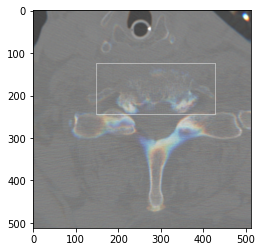

In [106]:
from torchvision.utils import draw_bounding_boxes
from time import time

def infer_slice(UID, axial_index):
    image, crop_box = get_image_and_labels_by_idx(IMAGES_DIR, boundary_df, UID, axial_index)
    image = image.crop(crop_box)
    transformed = transform(image=np.array(image, dtype=np.float32))
    image = transformed["image"]

    bboxes = model(image.to(device).unsqueeze(0))
    # print(bboxes.shape)
    bboxes = bboxes[0]

    image = (image * 0.5 + 0.5) * 255
    image = image.to(torch.uint8)
    # print(list(bboxes[:1, :5]))
    bbox_image = draw_bounding_boxes(image, boxes=bboxes[:1, :4], colors='white')
    plt.imshow(bbox_image.permute(1, 2, 0).cpu().numpy(), cmap='bone')

with torch.no_grad():
    start_time = time()
    model.eval()
    # model.max_detection_points = 1
    infer_slice('1.2.826.0.1.3680043.100', 229)
    
    print(time() - start_time)

In [112]:
infer_result = []

def read_batch_image(UID, slice, batch_size):
    image_list = []
    for i in range(batch_size):
        image, crop_box = get_image_and_labels_by_idx(IMAGES_DIR, boundary_df, UID, slice + i)
        image = image.crop(crop_box)
        transformed = transform(image=np.array(image, dtype=np.float32))
        image = transformed["image"]
        image_list.append(image)
    return torch.stack(image_list, dim=0)

def infer_patient_axial(UID):
    image_paths = glob.glob(os.path.join(IMAGES_DIR, UID) + '/*.jpeg')

    slice = 1
    end_slice = len(image_paths) - 2

    batch_size = 4

    bboxes_list = []

    for i in tqdm(range(math.ceil((end_slice-1) / batch_size))):
        batch_size = min(end_slice - slice, batch_size)
        images = read_batch_image(UID, slice, batch_size)
        images = images.to(device)
        class_out, box_out = model.model(images)
        # bboxes = decode_model_outputs(class_out, box_out, anchors)
        
        # bboxes = model(images)[0]
        
        # bboxes_list.extend(bboxes.cpu().numpy())
        
        slice += batch_size

    return np.array(bboxes_list)

with torch.no_grad():
    start_time = time()
    model.eval()
    model.max_detection_points = 1
    bboxes_list = infer_patient_axial('1.2.826.0.1.3680043.14405')
    
    print(time() - start_time)
    # plt.plot(bboxes_list[:, 4])
    # plt.show()
    # print(np.argmax(bboxes_list[:, 4]))

100%|██████████| 83/83 [00:07<00:00, 11.27it/s]

7.374016523361206


In [67]:
model.model.config.max_detection_points

5000

0.9834901


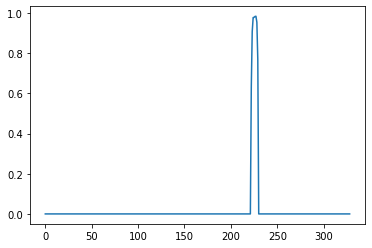

In [15]:
threshold = 0.6
class_list = bboxes_list[:, 4]
class_list[class_list < threshold] = 0
neg_list = 1 - class_list
neg_score = neg_list[0:-2] * neg_list[1:-1] * neg_list[2:]
pos_score = 1 - neg_score
print(pos_score.max())
plt.plot(pos_score)

In [ ]:
# plt.show()

In [ ]:
# bboxes_list

In [ ]:
# bboxes_list[96:105]

In [ ]:
# plt.plot(bboxes_list)